In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

from tqdm.notebook import tqdm

from scipy.ndimage import gaussian_filter, gaussian_filter1d

from qsa_pwfa.simulation import Simulation
from qsa_pwfa.ext_fields import GaussianBeam
from qsa_pwfa.species import NeutralUniformPlasma, NeutralNoneUniformPlasma, Grid
from qsa_pwfa.diagnostics import FieldDiagnostics
from qsa_pwfa.utils import get_density, get_field, get_Psi_new_grid

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
# Beam
n_b = 16.
R_b = 0.25
ksi0 = 5.
R_xi = 1.

# plasma
L_xi = 18.
L_r = 10.

# grid
N_xi = 512 * 8
N_r = 512

d_xi = L_xi / N_xi
dr = L_r / N_r

Q_tot = n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12
print(Q_tot)

1197.4784654024647


In [3]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi)

sim.add_specie( NeutralUniformPlasma(L_r=L_r, N_r=N_r) )

sim.diagnostics = [ 
    FieldDiagnostics( sim, Grid(L_r=L_r, N_r=N_r),
                           fields=['dPsi_dxi','Density', 'v_z', 'J_z'], 
                           xi_step=4,
                           species_src=sim.species
                    ),
    FieldDiagnostics( sim, Grid(L_r=L_r/3, N_r=N_r),
                           fields=['Density', ], 
                           xi_range=(7.1, 12.1), 
                           xi_step=1 )
]


beam_fld = GaussianBeam(n_b, R_b, ksi0, R_xi)
sim.add_external_field(beam_fld)

In [4]:
for i_xi in tqdm(range(N_xi-1)):
    sim.advance_xi(iter_max=50, rel_err_max=1e-2, mixing_factor=0.06)

  0%|          | 0/4095 [00:00<?, ?it/s]

/home/andriyash/mambaforge/lib/python3.9/site-packages/qsa_pwfa/species.py:89: RuntimeWarning: invalid value encountered in true_divide
  self.v_z /= dens_temp


<IPython.core.display.Javascript object>


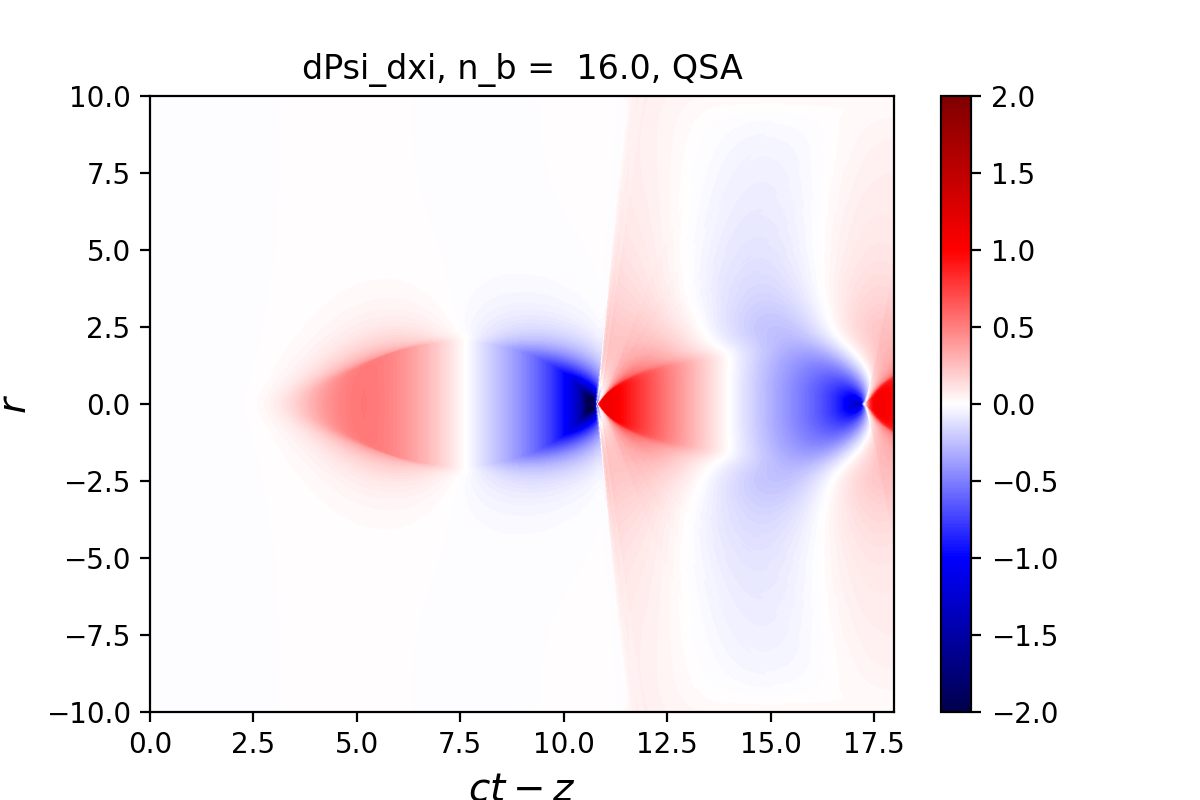

<IPython.core.display.Javascript object>


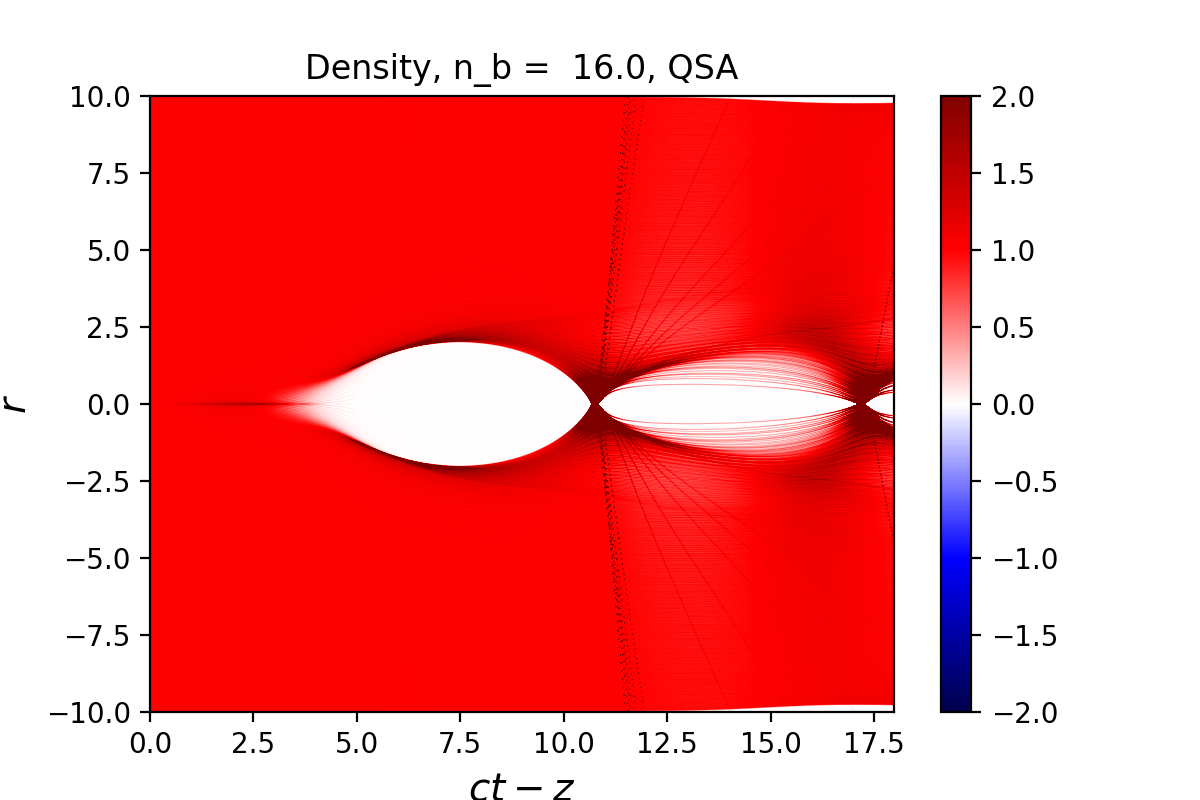

<IPython.core.display.Javascript object>


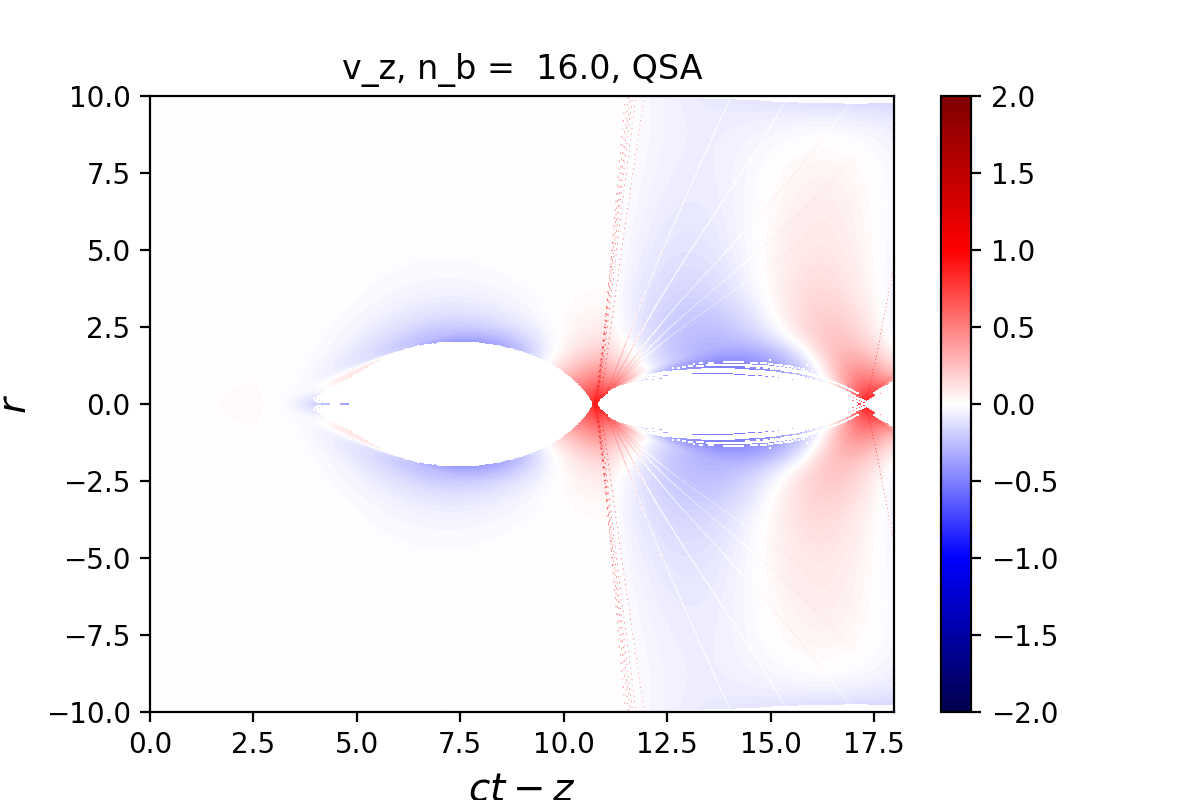

<IPython.core.display.Javascript object>


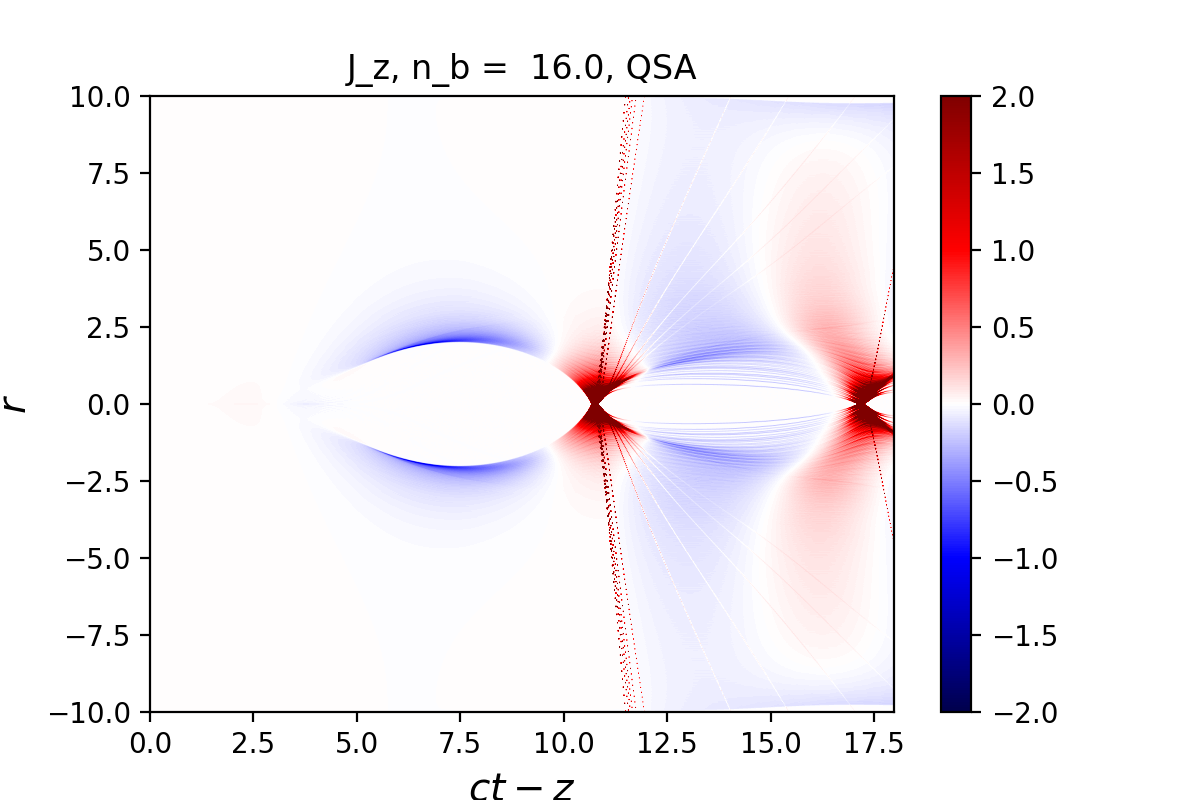

<IPython.core.display.Javascript object>


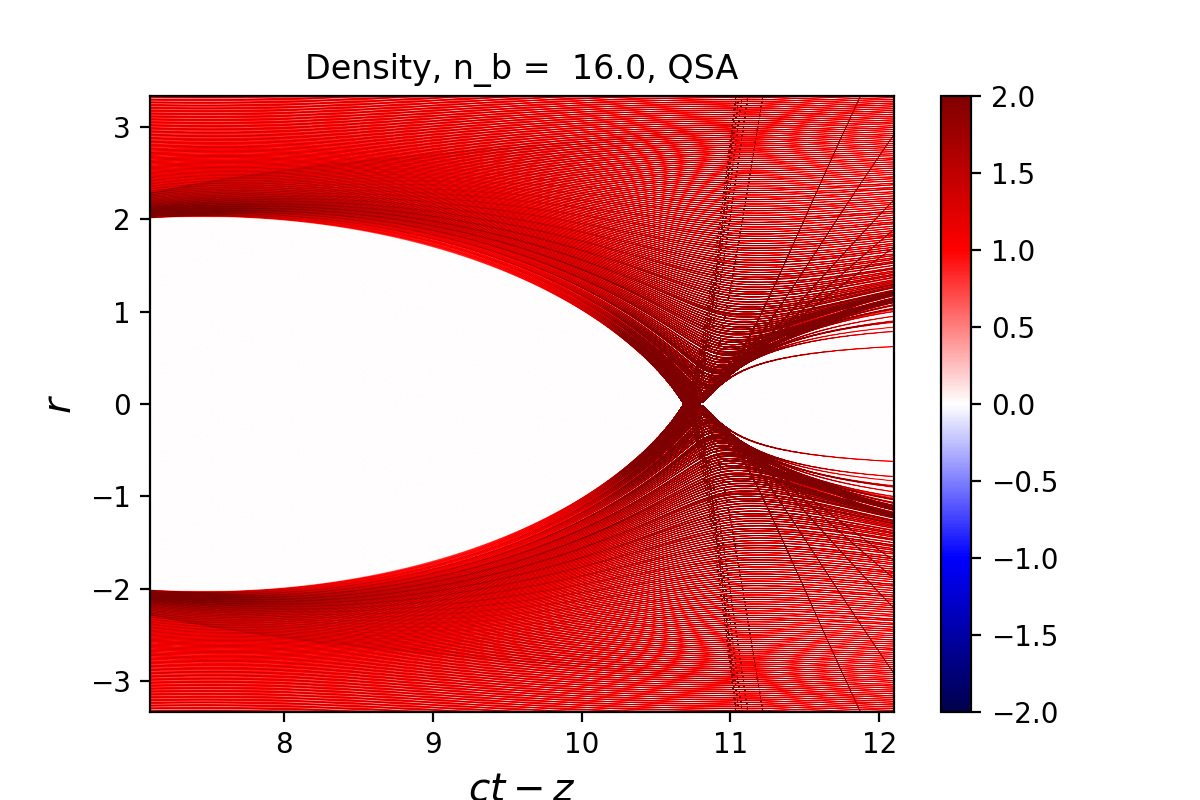

In [5]:
for diag in sim.diagnostics:
    ext = np.array([diag.xi.min(), 
                    diag.xi.max(),
                   -diag.grid.L_r, 
                    diag.grid.L_r ]) 
    
    for fld in diag.fields: 
        val = diag.Data[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

        plt.figure(figsize=(6,4))

        vmax = 2 # np.abs(val_ext).max()
        plt.imshow(val_ext.T,
                   origin='lower',
                   aspect='auto',
                   cmap=plt.cm.seismic,
                   vmax=vmax,
                   vmin=-vmax,
                   extent=ext
                  )

        plt.colorbar()
        plt.xlabel(r'$ct-z$', fontsize=14)
        plt.ylabel(r'$r$', fontsize=14)

        plt.title(f"{fld}, n_b =  {n_b}, QSA")